# Brain MRI Tumor Classification and Analysis (Xception Model)

>This notebook, developed and executed on **Kaggle**, provides a comprehensive walkthrough of a **Brain MRI Tumor Classification** pipeline using the **Xception** deep learning architecture.

>It focuses on demonstrating the key stages of the workflow, including **data preprocessing**, **model architecture design**, **training**, and **performance evaluation**.

>The primary goal of this notebook is to serve as an educational tutorial showcasing the model implementation and analysis rather than a production-level deployment.

## Import Needed Libraries

In [12]:
import os
import warnings
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception # Explicitly import the base model

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore")

# Define the output directory
OUTPUT_DIR = "/kaggle/working/"

## Preprocessing

### Load Data

Training Data Size: 5712 images
Full Testing Data Size: 1311 images

Training DataFrame Head:
                                          Class Path      Class
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary


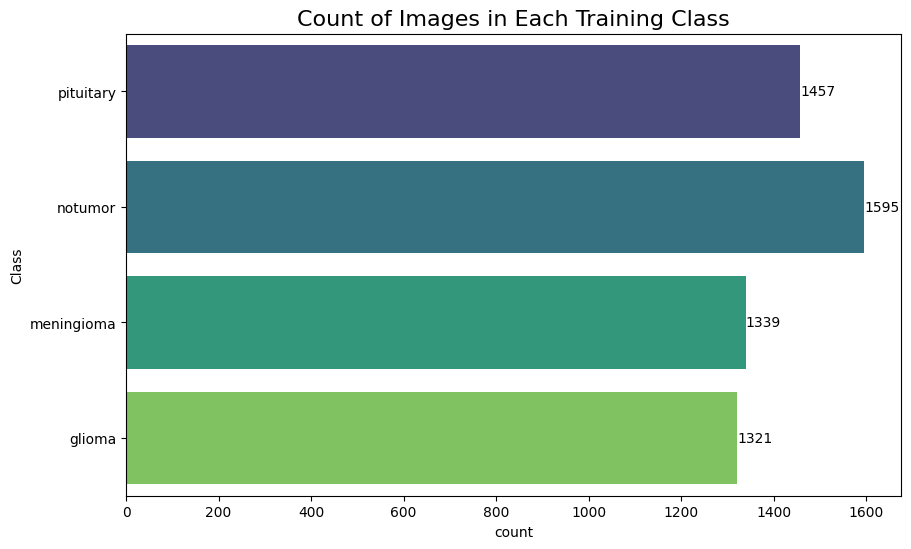

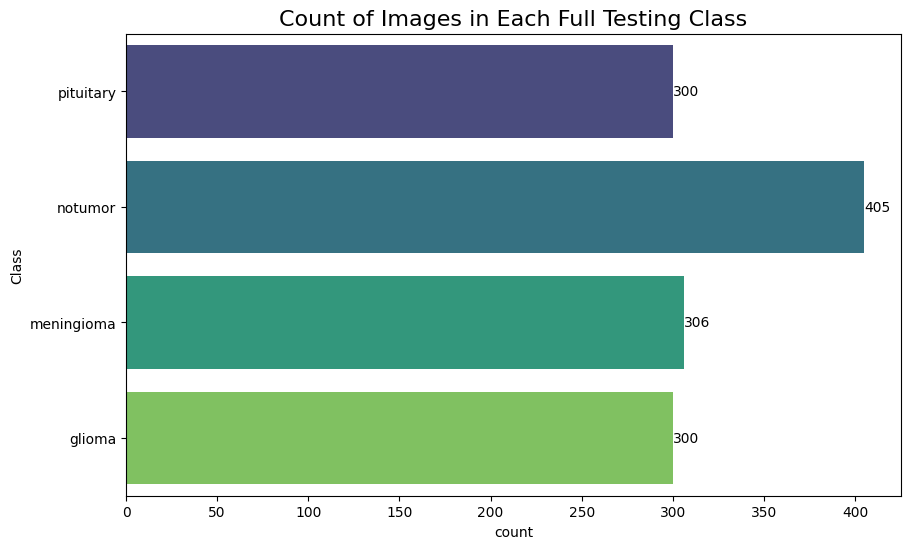


Validation Data Size: 655 images
Test Data Size: 656 images

Validation DataFrame Head:
                                             Class Path       Class
537   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
734   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma
470   /kaggle/input/brain-tumor-mri-dataset/Testing/...     notumor
1169  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
996   /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma


In [2]:
# Base path for the dataset (standard Kaggle input path)
DATASET_BASE_PATH = '/kaggle/input/brain-tumor-mri-dataset/'

def create_dataframe(data_path):
    """
    Creates a pandas DataFrame with 'Class Path' and 'Class' columns 
    by walking through the subdirectories of the given path.
    """
    class_paths = []
    classes = []
    
    # os.walk is generally safer and more robust than nested list comprehensions with os.listdir
    for dirpath, dirnames, filenames in os.walk(data_path):
        # The class label is the name of the immediate parent directory
        class_name = os.path.basename(dirpath)
        
        # We only care about subdirectories that contain image files
        if class_name != os.path.basename(data_path): # Skip the root 'Training' or 'Testing' folder itself
            for filename in filenames:
                if filename.endswith(('.jpg', '.jpeg', '.png')): # Filter for image files
                    class_paths.append(os.path.join(dirpath, filename))
                    classes.append(class_name)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

# Load Training and Testing dataframes
tr_df = create_dataframe(os.path.join(DATASET_BASE_PATH, 'Training'))
ts_full_df = create_dataframe(os.path.join(DATASET_BASE_PATH, 'Testing'))

print(f"Training Data Size: {len(tr_df)} images")
print(f"Full Testing Data Size: {len(ts_full_df)} images")

# Display a few samples
print("\nTraining DataFrame Head:")
print(tr_df.head())

# Visualize class distribution for the Training set
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=tr_df, y='Class', palette='viridis')
plt.title('Count of Images in Each Training Class', fontsize=16)
ax.bar_label(ax.containers[0])
plt.show()

# Visualize class distribution for the Full Testing set
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=ts_full_df, y='Class', palette='viridis')
plt.title('Count of Images in Each Full Testing Class', fontsize=16)
ax.bar_label(ax.containers[0])
plt.show()# Split the initial testing data (ts_full_df) into validation (valid_df) and final test (ts_df)
# train_size=0.5 means a 50/50 split.
valid_df, ts_df = train_test_split(
    ts_full_df, 
    train_size=0.5, 
    random_state=42, 
    stratify=ts_full_df['Class']
)

print(f"\nValidation Data Size: {len(valid_df)} images")
print(f"Test Data Size: {len(ts_df)} images")

print("\nValidation DataFrame Head:")
print(valid_df.head())

### Split Data to Train — Test — Valid

In [ ]:
# Split the initial testing data (ts_full_df) into validation (valid_df) and final test (ts_df)
# train_size=0.5 means a 50/50 split.
valid_df, ts_df = train_test_split(
    ts_full_df, 
    train_size=0.5, 
    random_state=42, 
    stratify=ts_full_df['Class']
)

print(f"\nValidation Data Size: {len(valid_df)} images")
print(f"Test Data Size: {len(ts_df)} images")

print("\nValidation DataFrame Head:")
print(valid_df.head())

### Data Preprocessing (Generators)

In [4]:
batch_size = 32
img_size = (299, 299) # Xception requires (299, 299) input size
seed = 42
NUM_CLASSES = len(tr_df['Class'].unique())

# Generator for Training: Augmentation (brightness) and Rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.8, 1.2),
    # Additional common augmentations can be added here, e.g., rotation, shift, zoom
)

# Generator for Validation/Testing: Only Rescaling (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
tr_gen = train_datagen.flow_from_dataframe(
    tr_df, 
    x_col='Class Path',
    y_col='Class', 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

# Validation Generator
valid_gen = test_datagen.flow_from_dataframe(
    valid_df, 
    x_col='Class Path',
    y_col='Class', 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

# Test Generator: Note the smaller batch_size and shuffle=False for predictable evaluation
ts_gen = test_datagen.flow_from_dataframe(
    ts_df, 
    x_col='Class Path',
    y_col='Class', 
    target_size=img_size,
    batch_size=16, # Smaller batch size for testing is fine
    class_mode='categorical',
    shuffle=False, # IMPORTANT: Must be False for correct evaluation metrics
    seed=seed
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


### Getting Samples from Data

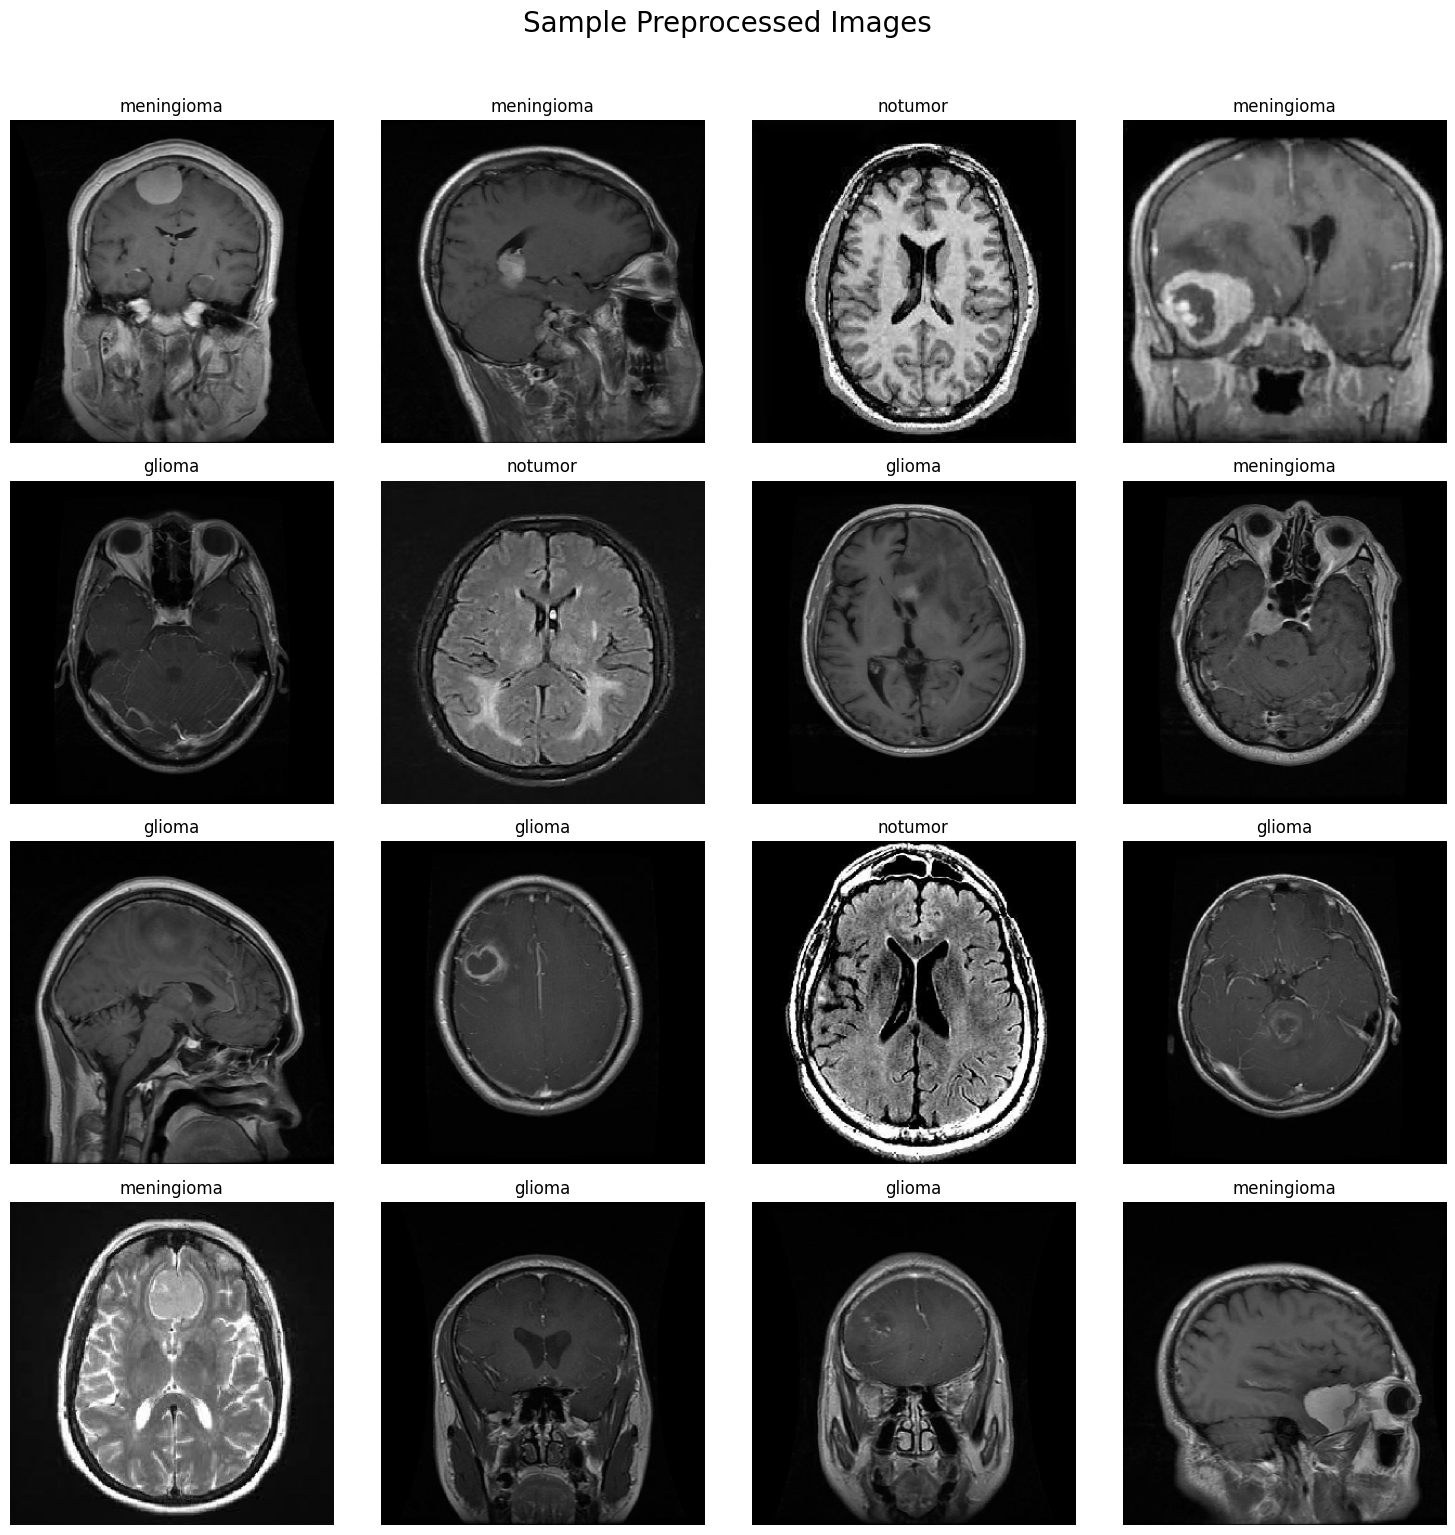

In [5]:
# Get class indices and labels
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

# Get a batch of images and labels from the test generator
images, labels = next(ts_gen)

plt.figure(figsize=(15, 15))
plt.suptitle('Sample Preprocessed Images', fontsize=20, y=1.02)
for i, (image, label) in enumerate(zip(images[:16], labels[:16])): # Show 16 images
    plt.subplot(4, 4, i + 1)
    # The image is already rescaled [0, 1]
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Building Deep Learning Model

I0000 00:00:1761480237.936129      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

None

Model architecture saved to model_architecture.png


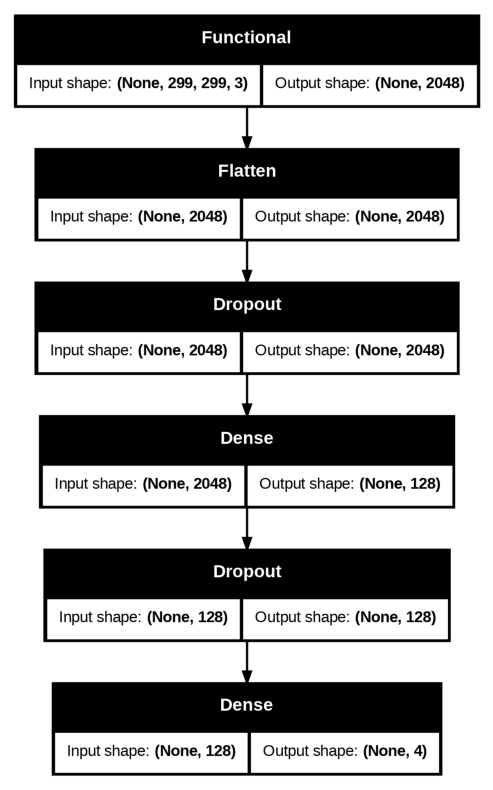

In [6]:
img_shape = (299, 299, 3)

# Load the Xception model, pre-trained on ImageNet, excluding the top classification layer
base_model = Xception(
    include_top=False, 
    weights='imagenet',
    input_shape=img_shape, 
    pooling='max' # Global max pooling to reduce feature map to a single vector (2048 length)
)

# Freeze the weights of the base model layers (initial training step)
for layer in base_model.layers:
    layer.trainable = False

# Build the Sequential model on top of the base model
model = Sequential([
    base_model,
    # Flatten is not needed because pooling='max' already created a 2048-length vector
    # However, keeping it matches your original structure:
    Flatten(), 
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(NUM_CLASSES, activation='softmax') # Final classification layer (4 classes)
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print(model.summary())

# Visualize the model architecture (requires graphviz)
try:
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='model_architecture.png')
    print("\nModel architecture saved to model_architecture.png")
    # Display the image in the notebook
    plt.figure(figsize=(10, 10))
    plt.imshow(plt.imread('model_architecture.png'))
    plt.axis('off')
    plt.show()
except ImportError:
    print("Skipping model plot visualization: Graphviz/pydot not installed.")

## Model Training

In [7]:
epochs = 10 

# Use callbacks for saving the best model or early stopping if needed in a real project
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print(f"Starting training for {epochs} epochs...")

hist = model.fit(
    tr_gen,
    epochs=epochs,
    validation_data=valid_gen,
    shuffle=False # Shuffle is handled by the generator itself
)

print("\nTraining complete.")

Starting training for 10 epochs...
Epoch 1/10


I0000 00:00:1761480256.173596      84 service.cc:148] XLA service 0x7ed4f443ca60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761480256.174693      84 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761480257.188377      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/179 ━━━━━━━━━━━━━━━━━━━━ 49:00 17s/step - accuracy: 0.3125 - loss: 3.4066 - precision: 0.2963 - recall: 0.2500

I0000 00:00:1761480265.884253      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6346 - loss: 1.0552 - precision: 0.6842 - recall: 0.5789

E0000 00:00:1761480337.545216      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761480337.781943      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761480338.307398      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761480338.567515      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 420ms/step - accuracy: 0.6351 - loss: 1.0533 - precision: 0.6847 - recall: 0.5795 - val_accuracy: 0.8046 - val_loss: 0.4335 - val_precision: 0.8504 - val_recall: 0.7725
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.8207 - loss: 0.4624 - precision: 0.8514 - recall: 0.7829 - val_accuracy: 0.8305 - val_loss: 0.3724 - val_precision: 0.8675 - val_recall: 0.8000
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 210ms/step - accuracy: 0.8548 - loss: 0.3932 - precision: 0.8730 - recall: 0.8329 - val_accuracy: 0.8626 - val_loss: 0.3324 - val_precision: 0.8889 - val_recall: 0.8305
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.8728 - loss: 0.3450 - precision: 0.8884 - recall: 0.8565 - val_accuracy: 0.8626 - val_loss: 0.3091 - val_precision: 0.8851 - val_recall: 0.8351
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 218ms/step - accuracy: 0.8805 - loss: 0.3291 - precision: 0.8934 - recall: 0.8650 - val_accuracy: 0.8733 - val_loss

## Visualize Model Performance

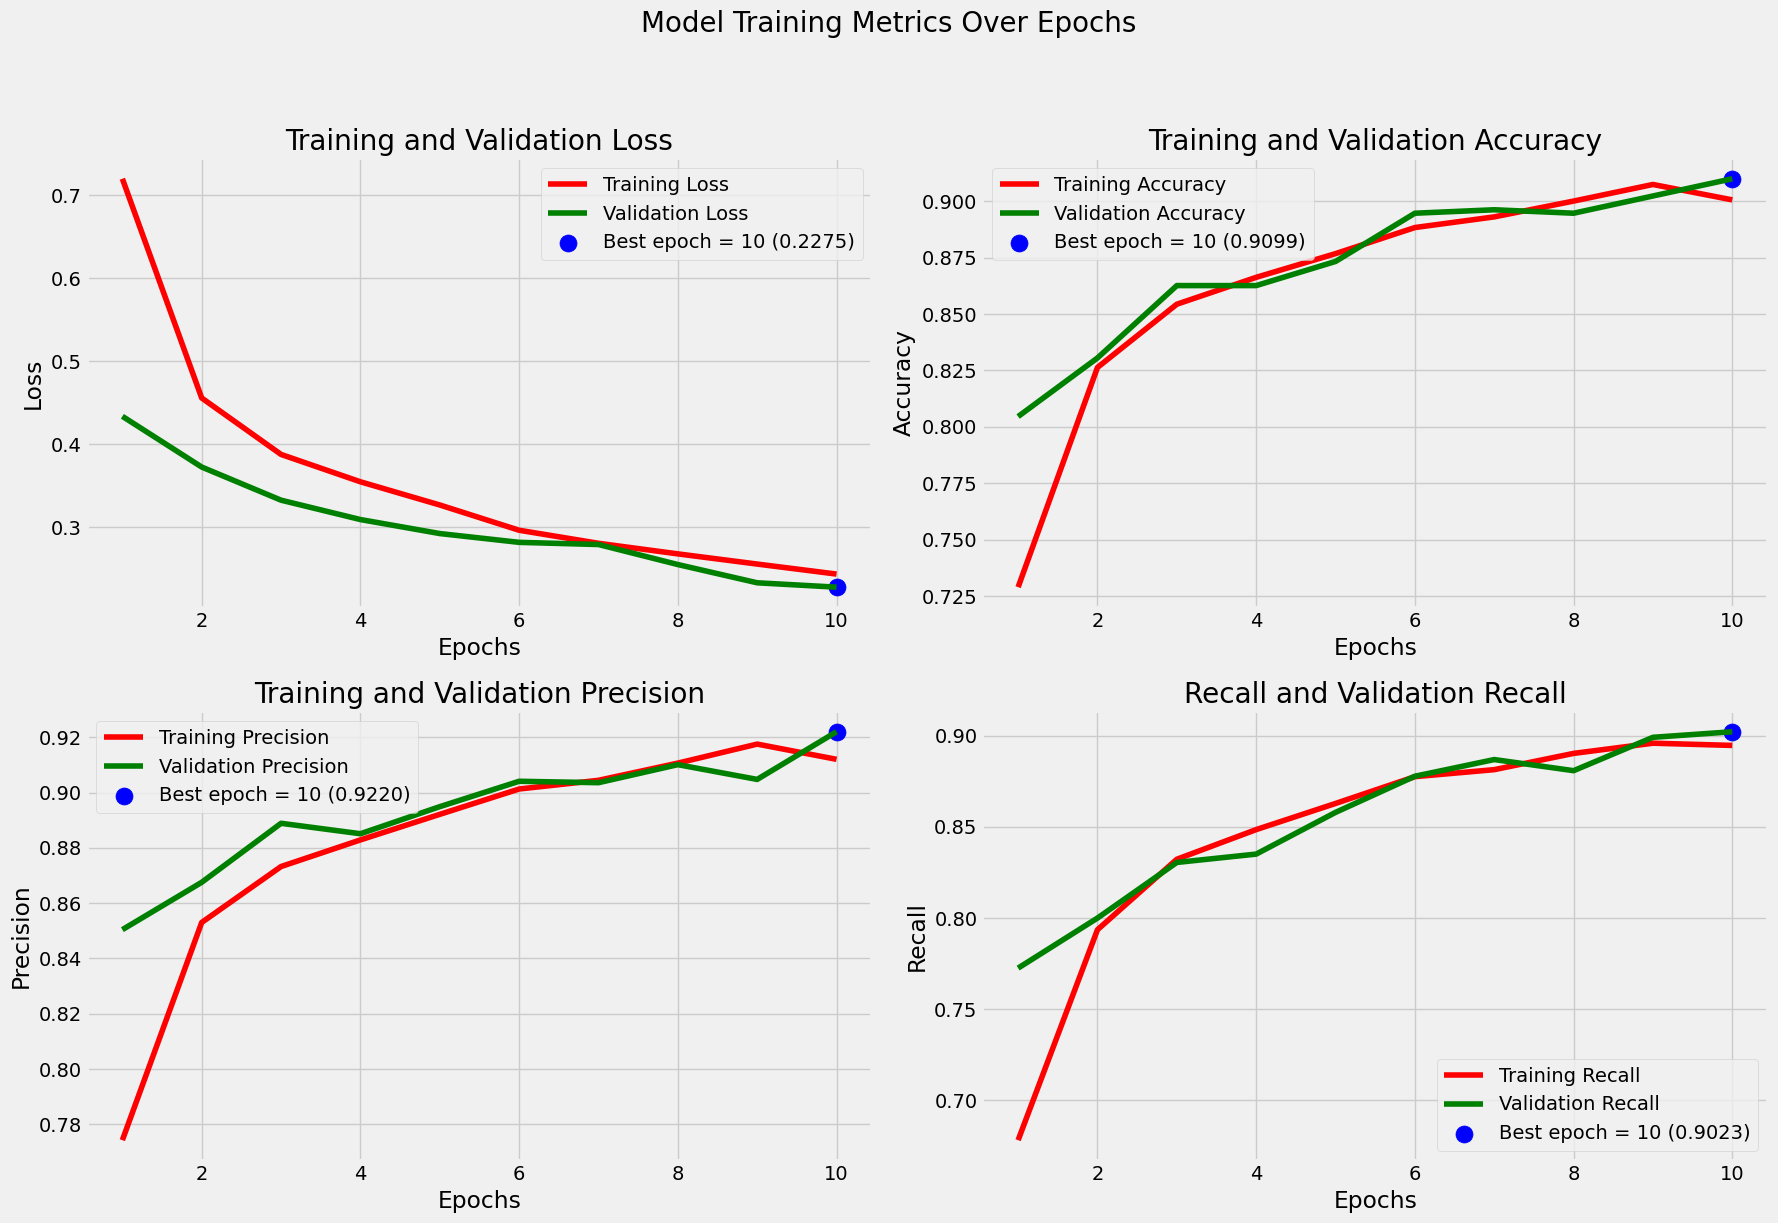

In [10]:
# --- Your existing code for calculating metrics ---
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']

val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

Epochs = [i + 1 for i in range(len(tr_acc))]

# Find best epochs for validation metrics
index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
index_precision = np.argmax(val_per)
index_recall = np.argmax(val_recall)

# Labels for scatter points
loss_label = f'Best epoch = {index_loss + 1} ({val_loss[index_loss]:.4f})'
acc_label = f'Best epoch = {index_acc + 1} ({val_acc[index_acc]:.4f})'
per_label = f'Best epoch = {index_precision + 1} ({val_per[index_precision]:.4f})'
recall_label = f'Best epoch = {index_recall + 1} ({val_recall[index_recall]:.4f})'

# --- Your existing plotting code ---
plt.figure(figsize=(18, 12))
plt.style.use('fivethirtyeight')

# Plot 1: Loss
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_loss[index_loss], s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_acc[index_acc], s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Precision
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Training Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, val_per[index_precision], s=150, c='blue', label=per_label)
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Plot 4: Recall
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Training Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, val_recall[index_recall], s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# --- ADDED CODE TO SAVE FIGURE ---
SAVE_PATH = os.path.join(OUTPUT_DIR, "training_metrics_plot.png")
plt.savefig(SAVE_PATH)

## Testing and Evaluation

### Evaluate

Train Accuracy: 94.71% (Loss: 0.1498)
----------------------------------------
Validation Accuracy: 90.99% (Loss: 0.2275)
----------------------------------------
Test Accuracy: 91.31% (Loss: 0.2358)
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

Confusion matrix plot saved to: /kaggle/working/confusion_matrix.png


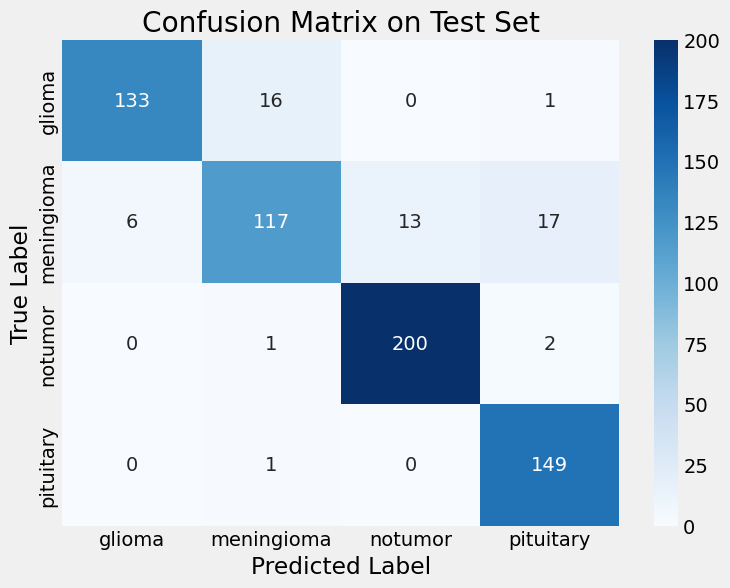


Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      0.89      0.92       150
  meningioma       0.87      0.76      0.81       153
     notumor       0.94      0.99      0.96       203
   pituitary       0.88      0.99      0.93       150

    accuracy                           0.91       656
   macro avg       0.91      0.91      0.91       656
weighted avg       0.91      0.91      0.91       656

Classification report text saved to: /kaggle/working/classification_report.txt


In [13]:
# Evaluate scores
train_score = model.evaluate(tr_gen, verbose=0)
valid_score = model.evaluate(valid_gen, verbose=0)
test_score = model.evaluate(ts_gen, verbose=0)

print(f"Train Accuracy: {train_score[1]*100:.2f}% (Loss: {train_score[0]:.4f})")
print('-' * 40)
print(f"Validation Accuracy: {valid_score[1]*100:.2f}% (Loss: {valid_score[0]:.4f})")
print('-' * 40)
print(f"Test Accuracy: {test_score[1]*100:.2f}% (Loss: {test_score[0]:.4f})")

# Predict on the test set
# The test generator (ts_gen) was created with shuffle=False, so the indices are preserved.
preds = model.predict(ts_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)

# Generate Confusion Matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=labels, 
    yticklabels=labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')

# --- ADDED CODE TO SAVE CONFUSION MATRIX FIGURE ---
CM_SAVE_PATH = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
plt.savefig(CM_SAVE_PATH)
print(f"\nConfusion matrix plot saved to: {CM_SAVE_PATH}")
# --------------------------------------------------

plt.show()

# Generate Classification Report
clr = classification_report(ts_gen.classes, y_pred, target_names=labels)
print("\nClassification Report:\n")
print(clr)

# --- ADDED CODE TO SAVE CLASSIFICATION REPORT TEXT ---
REPORT_SAVE_PATH = os.path.join(OUTPUT_DIR, "classification_report.txt")
with open(REPORT_SAVE_PATH, 'w') as f:
    f.write(clr)
print(f"Classification report text saved to: {REPORT_SAVE_PATH}")
# -----------------------------------------------------

### Testing Single Images


--- Testing Single Images ---


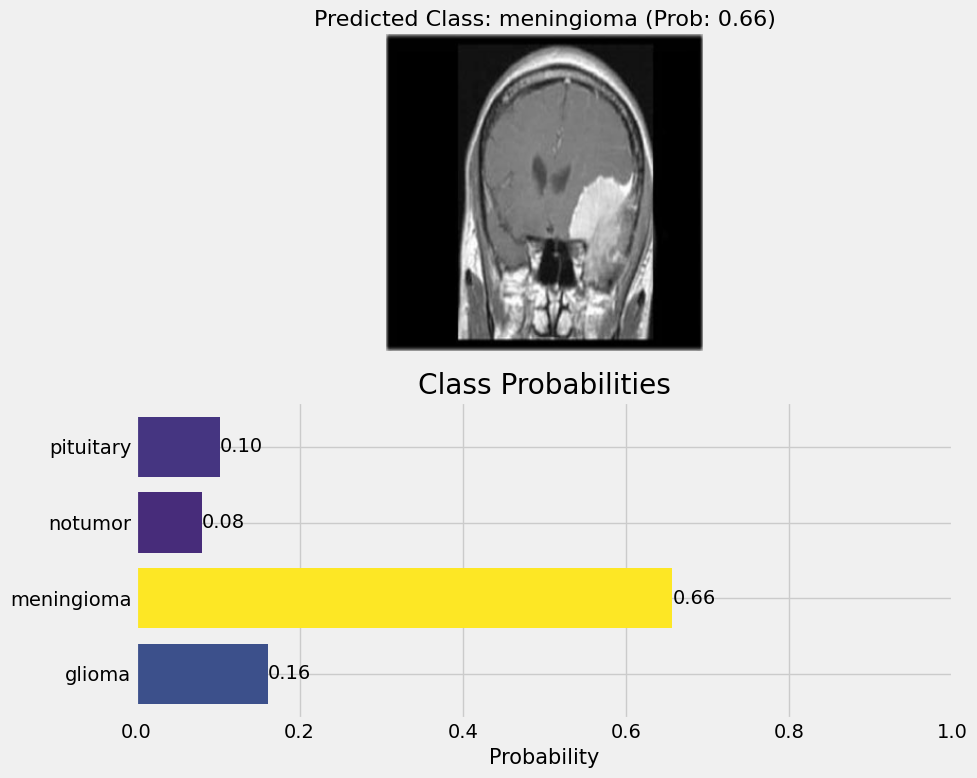

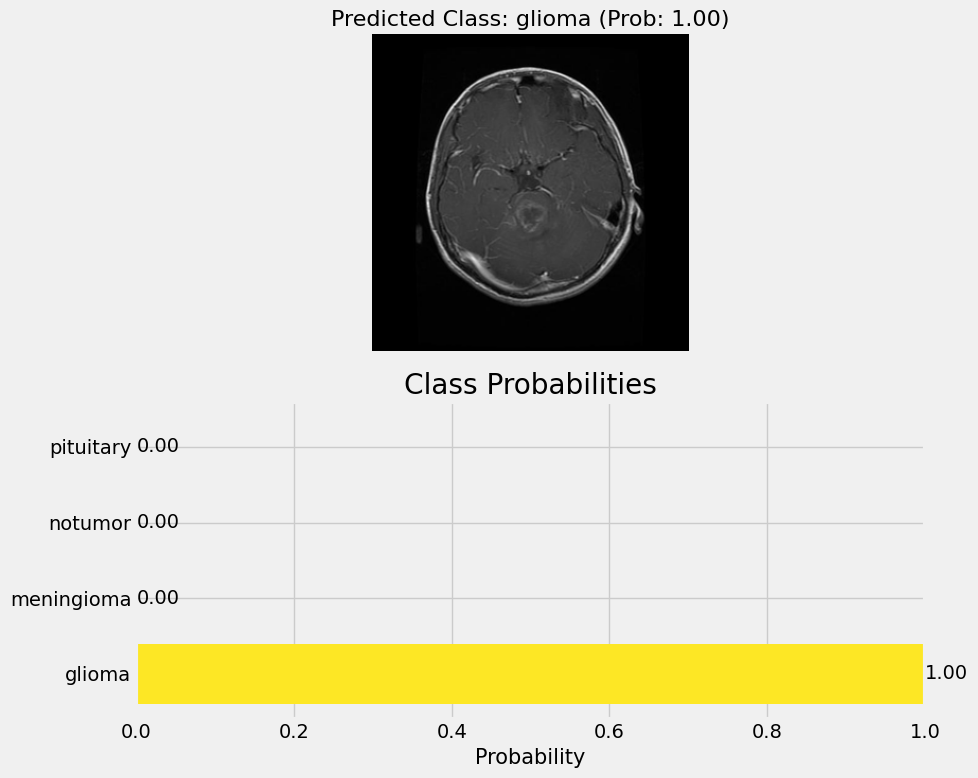

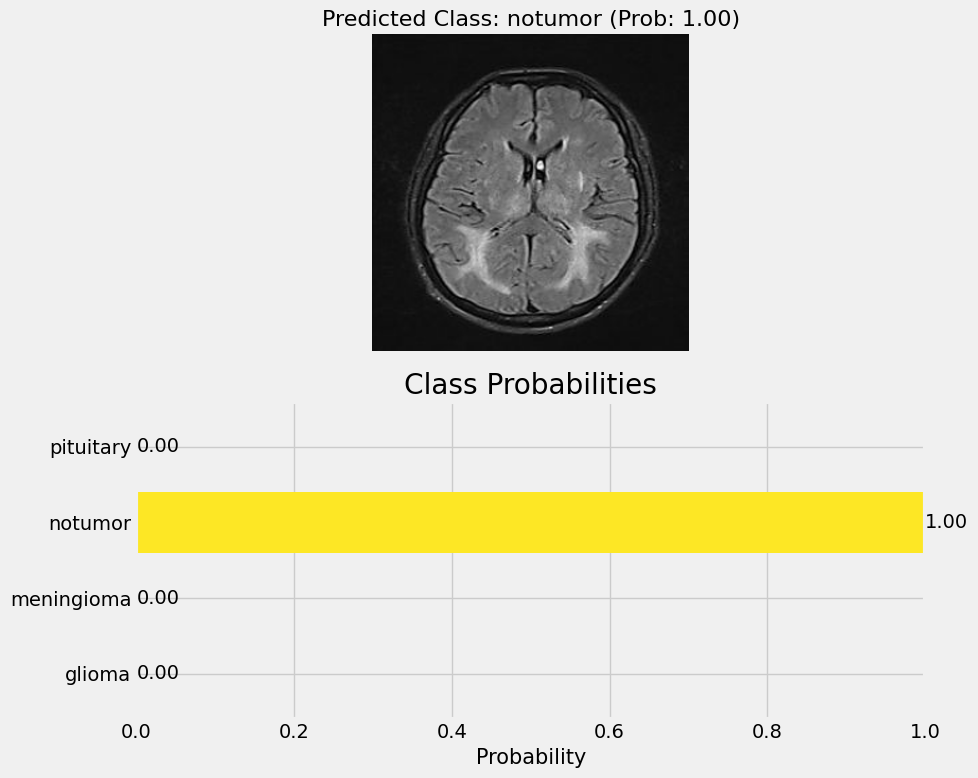

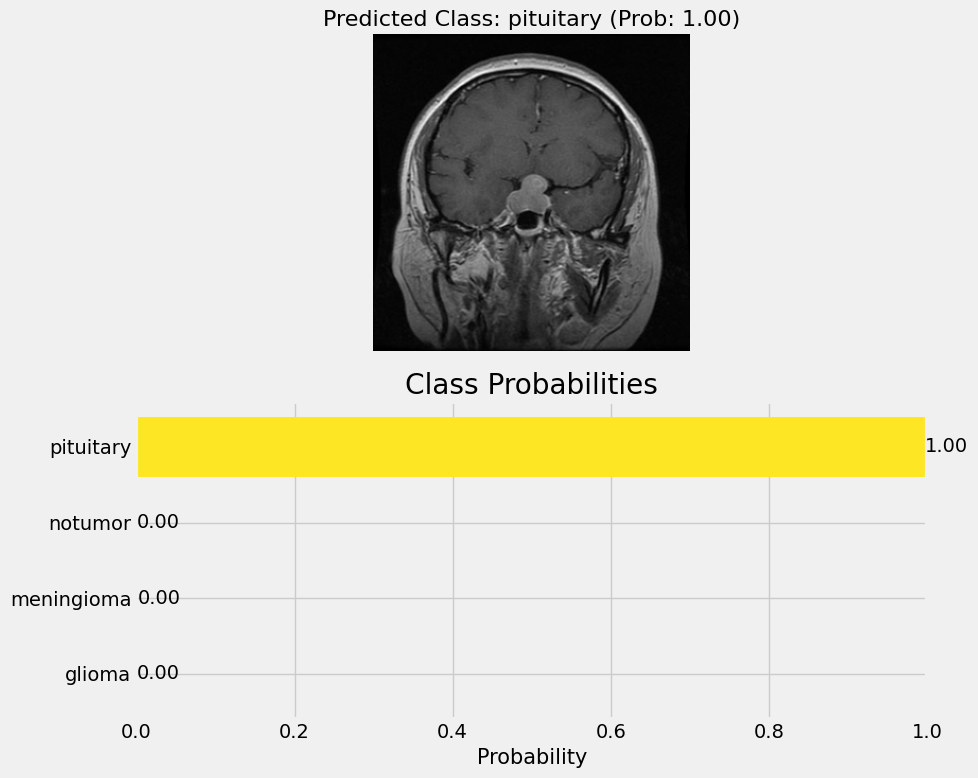

In [14]:
def predict_single_image(img_path, model, class_dict, target_size=(299, 299)):
    """
    Predicts the class of a single image, displays the image, and shows probability scores.
    """
    labels = list(class_dict.keys())
    
    # 1. Load and Preprocess Image
    try:
        img = Image.open(img_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: File not found at {img_path}")
        return

    resized_img = img.resize(target_size)
    
    # Convert to array, expand dimensions (1, H, W, C), and rescale
    img_array = np.asarray(resized_img)
    img_input = np.expand_dims(img_array, axis=0)
    img_input = img_input / 255.0

    # 2. Prediction
    predictions = model.predict(img_input, verbose=0)
    probs = predictions[0]
    
    # 3. Visualization
    plt.figure(figsize=(10, 8))

    # Subplot 1: Image
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    predicted_class_index = np.argmax(probs)
    predicted_class = labels[predicted_class_index]
    plt.title(f"Predicted Class: {predicted_class} (Prob: {probs[predicted_class_index]:.2f})", 
              fontsize=16)
    plt.axis('off')

    # Subplot 2: Probability Bar Chart
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs, color=plt.cm.viridis(probs / np.max(probs)))
    plt.xlabel('Probability', fontsize=15)
    plt.title('Class Probabilities')
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    plt.xlim(0, 1) # Ensure probabilities are between 0 and 1
    
    plt.tight_layout()
    plt.show()

# Example predictions using paths from the original testing split (ts_df)
print("\n--- Testing Single Images ---")
predict_single_image(
    '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg', 
    model, 
    class_dict
)
predict_single_image(
    '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg', 
    model, 
    class_dict
)
predict_single_image(
    '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg', 
    model, 
    class_dict
)
predict_single_image(
    '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg', 
    model, 
    class_dict
)

### Model Saving

In [15]:
MODEL_FILENAME = "brain_tumor_xception_model.keras" # Recommended Keras native format
MODEL_PATH = os.path.join(OUTPUT_DIR, MODEL_FILENAME)

# Create the directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Save the entire model (architecture, weights, and training configuration)
try:
    model.save(MODEL_PATH)
    print(f"\nModel successfully saved to: {MODEL_PATH}")
    
    # You can verify the file size
    file_size = os.path.getsize(MODEL_PATH) / (1024 * 1024) # Convert to MB
    print(f"File size: {file_size:.2f} MB")
    
except Exception as e:
    print(f"\nError saving the model: {e}")


Model successfully saved to: /kaggle/working/brain_tumor_xception_model.keras
File size: 83.08 MB
